# Canonical Polyadic Decomposition

This notebook is to implement CPD on some frequency domain data, and assess the compress-decompress times when used for compression.

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import TensorFox as tfx
import h5py

In [2]:
def loadBradyHShdf5(file,normalize='yes'):
    '''

    Parameters
    ----------
    file : str
        path to brady hotspring h5py data file
    normalize : str, optional
        "yes" or "no". Indicates whether or not to remove laser drift and 
        normalize. The default is 'yes'.

    Returns
    -------
    data : np array
        channel by samples numpy array of data
    timestamp_arr : numpy array
        array of the timestamps corresponding to the various samples in the 
        data. Timestamps for brady hotspring data are with respect to the 
        beginning time of the survey.

    '''
    
    with h5py.File(file,'r') as open_file: 
        dataset = open_file['das']
        time=open_file['t']
        data=np.array(dataset)
        timestamp_arr=np.array(time)
    data = np.transpose(data)
    if normalize=='yes':
        nSamples=np.shape(data)[1]
        # get rid of laser drift
        med = np.median(data,axis=0)
        for i in range(nSamples):
          data[:,i] = data[:,i] - med[i]
          
        max_of_rows = abs(data[:,:]).sum(axis=1)
        data = data/ max_of_rows[:, np.newaxis]
    return data, timestamp_arr


def windowed_spectra(data: np.array, subwindow_len: int,overlap,freq=None,sample_interval=1):
    """
    Calculate the frequency domain representation of data in windows.
    """

    win_start = 0
    window_samples = int(subwindow_len / sample_interval)
    total_samples = data.shape[-1]
    overlap = int(overlap/sample_interval)
    intervals = np.arange(window_samples, total_samples+1, window_samples, dtype=int) # break time series into windowed intervals

    win_end = intervals[0]

    absolute_spectra = np.fft.rfft(data[:,win_start:win_end])
    win_spectra = absolute_spectra[np.newaxis]

    while win_end < total_samples:
        win_start = win_end - overlap
        win_end = win_start + window_samples
        absolute_spectra = np.fft.rfft(data[:,win_start:win_end])
        win_spectra = np.append(
            win_spectra, absolute_spectra[np.newaxis], axis=0
        )
        # win_start = win_end
        
    
    frequencies = np.fft.rfftfreq(window_samples, sample_interval)

    return win_spectra, frequencies

In [3]:
samples_per_sec=1000
fsize=15
start_ch = 1000
nchannels = 3000

In [4]:
file = r"D:\CSM\Mines_Research\Test_data\Brady Hotspring\PoroTomo_iDAS16043_160312000018.h5"
data_noise,_= loadBradyHShdf5(file,normalize='no')

file = r"D:\CSM\Mines_Research\Test_data\Brady Hotspring\PoroTomo_iDAS16043_160312000048.h5"
data_noise2,_= loadBradyHShdf5(file,normalize='no')

data_noise = np.append(data_noise,data_noise2,axis=1)

In [5]:
win_spectra, frequencies = windowed_spectra(data_noise[start_ch:nchannels+start_ch:int(nchannels/200)], 5, 2.5, sample_interval=0.001)

In [6]:
win_spectra[:,:23,:23].shape

(23, 23, 23)

T is a tensor of dimensions (23, 200, 2501)

|T| = 2619.0251570884434

max(T) = 146.20243010247808

min(T) = -199.33211946205304

mean(T) = 0.00039390169286237803

mean(|T|) = 0.2231897232779525

var(T) = 0.546408099892744



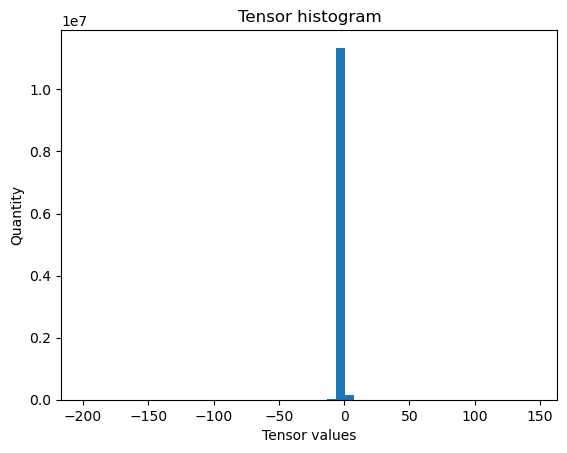


1 <= rank(T) <= 500200

Generic rank of the tensor space of T = 4227

Computing multilinear rank...
------------------------------------
    Compressing unfolding mode 1
    Compressing unfolding mode 2
    Compressing unfolding mode 3
multirank(T) = (23, 200, 2473)
|T - (U_1, ..., U_3)*S|/|T| = 0.000574578908097914

Computing rank...
Start searching for rank
Stops at R = 4600  or less
-----------------------------
Testing R = 283

In [7]:
# Create a 2 x 2 x 2 tensor.
m = 5
T = np.zeros((m, m, m))
s = 0.0

for k in range(m):
    for i in range(m):
        for j in range(m):
            T[i,j,k] = s
            s += 1

# Let's see some information about T.
# tfx.infotens(T)
tfx.infotens(win_spectra.real)

In [22]:
rank = 17
# factors, output = tfx.cpd(win_spectra[:6,:6,:6].real, rank)
factors, output = tfx.cpd(win_spectra.real, rank)

In [29]:
X = factors[0]
Y = factors[1]
Z = factors[2]

X.shape
print(f"{X.shape = }")
print(f"{Y.shape = }")
print(f"{Z.shape = }")

X.shape = (6, 17)
Y.shape = (6, 17)
Z.shape = (6, 17)


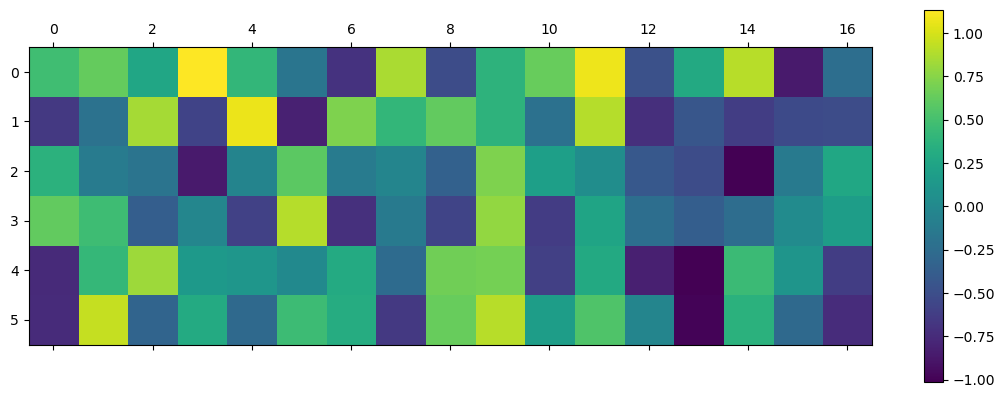

In [38]:
# plt.subplot(3,1,1)
plt.matshow(X)
plt.colorbar()